## Multichannel autoencoders for anomaly detection example

In [1]:
%load_ext autoreload
#%load_ext nb_black
%load_ext autotime
%autoreload 2


from matplotlib import pyplot as plt
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 2]
plt.rcParams["figure.dpi"] = 200

random.seed(42)
np.random.seed(42)

time: 443 ms (started: 2024-05-28 19:21:44 -07:00)


### Generate a synthetic time series

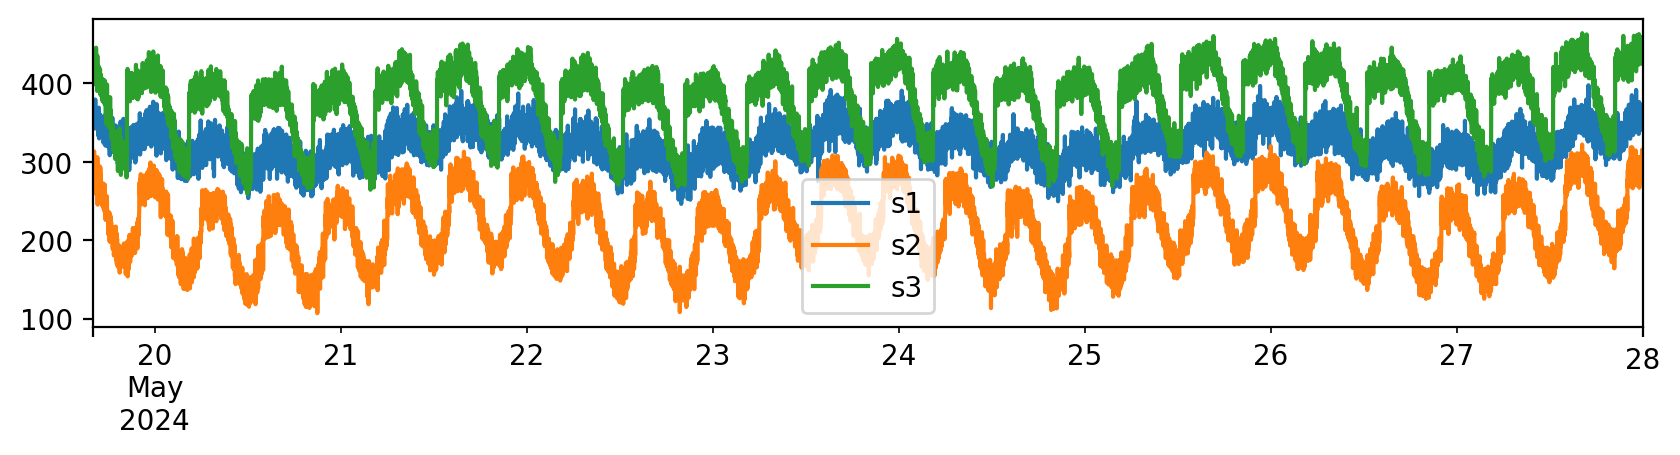

time: 2.02 s (started: 2024-05-28 19:21:45 -07:00)


In [2]:
from numalogic.synthetic import SyntheticTSGenerator
from numalogic.synthetic import AnomalyGenerator

ts_generator = SyntheticTSGenerator(
    seq_len=12000,
    num_series=3,
    freq="T",
    primary_period=480,
    secondary_period=3000,
    seasonal_ts_prob=1.0,
    baseline_range=(200.0, 350.0),
    slope_range=(-0.001, 0.01),
    amplitude_range=(10, 75),
    cosine_ratio_range=(0.5, 0.9),
    noise_range=(10, 15),
)
ts_df = ts_generator.gen_tseries()
ts_df.plot();

### Divide into train, test and validation set

In [3]:
train_df, test_df = ts_generator.train_test_split(ts_df, test_size=2400)
train_df, val_df = ts_generator.train_test_split(train_df, test_size=2000)
train_df.shape, val_df.shape, test_df.shape

((7600, 3), (2000, 3), (2400, 3))

time: 2.25 ms (started: 2024-05-28 19:21:47 -07:00)


### Inject synthetic anomalies in the test data
Let's generate a contextual anomaly with a low impact.


In [4]:
anomaly_generator = AnomalyGenerator(
    train_df, anomaly_type="contextual", anomaly_ratio=0.2
)
outlier_test_df = anomaly_generator.inject_anomalies(test_df, cols=["s1"], impact=3)

time: 8.95 ms (started: 2024-05-28 19:21:47 -07:00)


<Axes: >

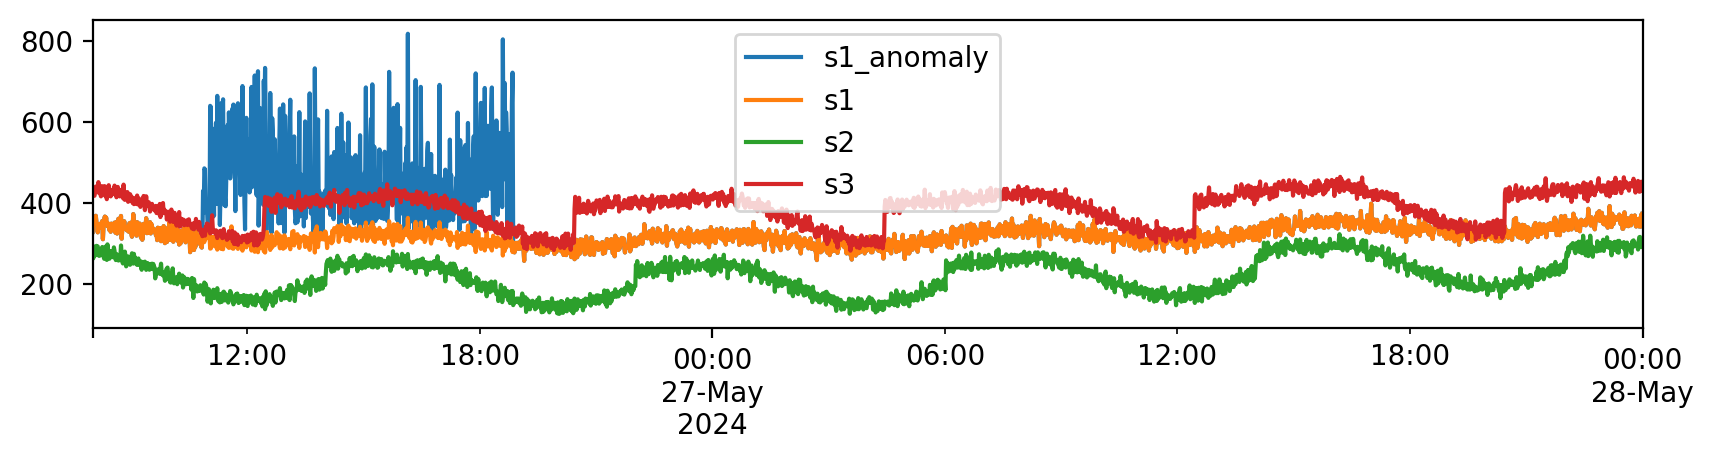

time: 465 ms (started: 2024-05-28 19:21:47 -07:00)


In [5]:
outlier_test_df.rename(columns={"s1": "s1_anomaly"}, inplace=True)
fig, ax = plt.subplots()
outlier_test_df[["s1_anomaly"]].plot(ax=ax)
test_df.plot(ax=ax)

### Preprocess the data
We will use the Tanh scaler here from numalogic.

In [6]:
from numalogic.transforms import TanhScaler

# The second column is with anomalies, the rest are normal
outlier_test_df['s1'] = test_df['s1']
outlier_test_df['s2'] = outlier_test_df['s1_anomaly']
outlier_test_df['s3'] = test_df['s3']

scaler = TanhScaler()
x_train = scaler.fit_transform(train_df.to_numpy())
x_val = scaler.transform(val_df.to_numpy())
x_test = scaler.transform(outlier_test_df[['s1', 's2', 's3']].to_numpy())
x_test_good = scaler.transform(test_df.to_numpy())

time: 1.9 s (started: 2024-05-28 19:21:47 -07:00)


Show the shape of the data

In [7]:
print(x_train.shape)
x_train[:2]

(7600, 3)


array([[0.6892569 , 0.65943093, 0.6046258 ],
       [0.6845073 , 0.61155719, 0.58491959]])

time: 2.81 ms (started: 2024-05-28 19:21:49 -07:00)


### Define model training parameters
First, we will prepare some torch datasets

In [8]:
from numalogic.tools.data import StreamingDataset
from torch.utils.data import DataLoader


SEQ_LEN = 12
BATCH_SIZE = 64
MAX_EPOCHS = 40

train_dataset = StreamingDataset(x_train, seq_len=SEQ_LEN)
val_dataset = StreamingDataset(x_val, seq_len=SEQ_LEN)
test_dataset = StreamingDataset(x_test, seq_len=SEQ_LEN)

time: 1.74 ms (started: 2024-05-28 19:21:49 -07:00)


Show again a sample of the train data

In [9]:
train_dataset[0]

array([[0.6892569 , 0.6594309 , 0.6046258 ],
       [0.6845073 , 0.6115572 , 0.5849196 ],
       [0.6502014 , 0.65032077, 0.6250815 ],
       [0.7006228 , 0.62659645, 0.6311284 ],
       [0.669699  , 0.6564822 , 0.63159466],
       [0.6031162 , 0.6508799 , 0.59877324],
       [0.6648284 , 0.6672394 , 0.5800368 ],
       [0.59778583, 0.6739822 , 0.58749616],
       [0.68887925, 0.66089535, 0.6131313 ],
       [0.64401907, 0.66932815, 0.5673628 ],
       [0.63716394, 0.6429359 , 0.6380219 ],
       [0.6117859 , 0.70930326, 0.59811866]], dtype=float32)

time: 1.91 ms (started: 2024-05-28 19:21:49 -07:00)


Define a vanilla autoencoder model

In [10]:
from numalogic.models.autoencoder.variants import VanillaAE
from numalogic.models.autoencoder import TimeseriesTrainer

model_vanilla = VanillaAE(seq_len=SEQ_LEN, n_features=3)
print(model_vanilla)

VanillaAE(
  (encoder): _VanillaEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=12, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=8, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.25, inplace=False)
    )
  )
  (decoder): _Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=12, bias=True)
    )
  )
)
time: 11.4 ms (started: 2024-05-28 19:21:49 -07:00)


In [11]:
trainer = TimeseriesTrainer(max_epochs=MAX_EPOCHS, enable_progress_bar=True)
trainer.fit(model_vanilla, train_dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=40` reached

time: 20 s (started: 2024-05-28 19:21:49 -07:00)


In [12]:
train_reconerr_vanilla = trainer.predict(
    model_vanilla, dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE)
).numpy()
val_reconerr_vanilla = trainer.predict(
    model_vanilla, dataloaders=DataLoader(val_dataset, batch_size=BATCH_SIZE)
).numpy()
test_reconerr_vanilla = trainer.predict(
    model_vanilla, dataloaders=DataLoader(test_dataset, batch_size=BATCH_SIZE)
).numpy()

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

time: 474 ms (started: 2024-05-28 19:22:09 -07:00)


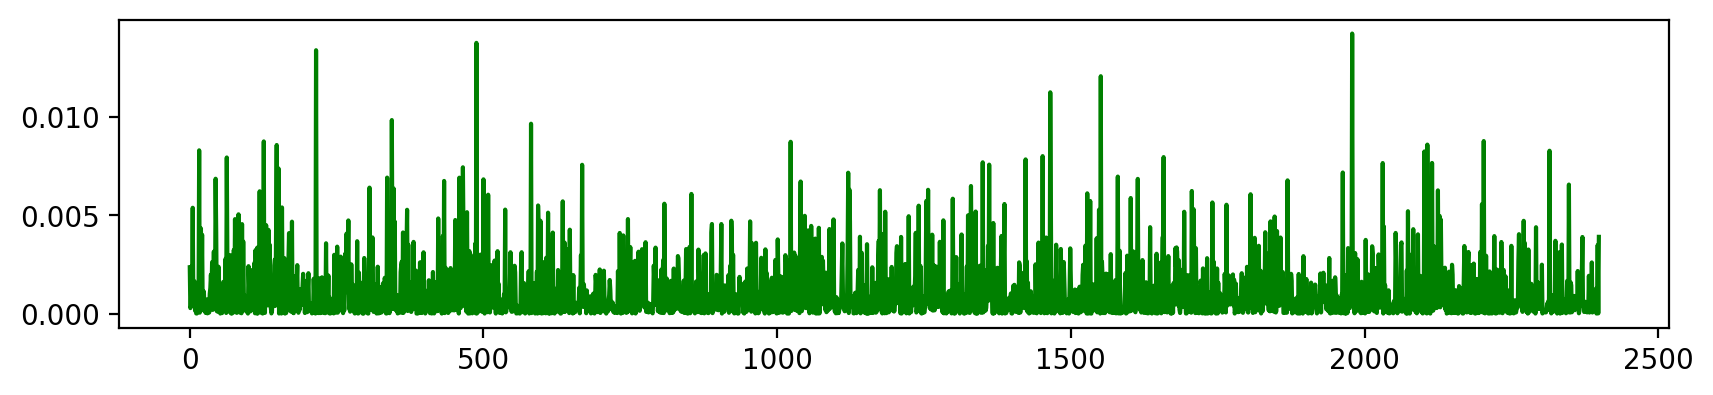

time: 143 ms (started: 2024-05-28 19:22:10 -07:00)


In [13]:
fig = plt.plot(test_reconerr_vanilla[:, [0]], color="g")

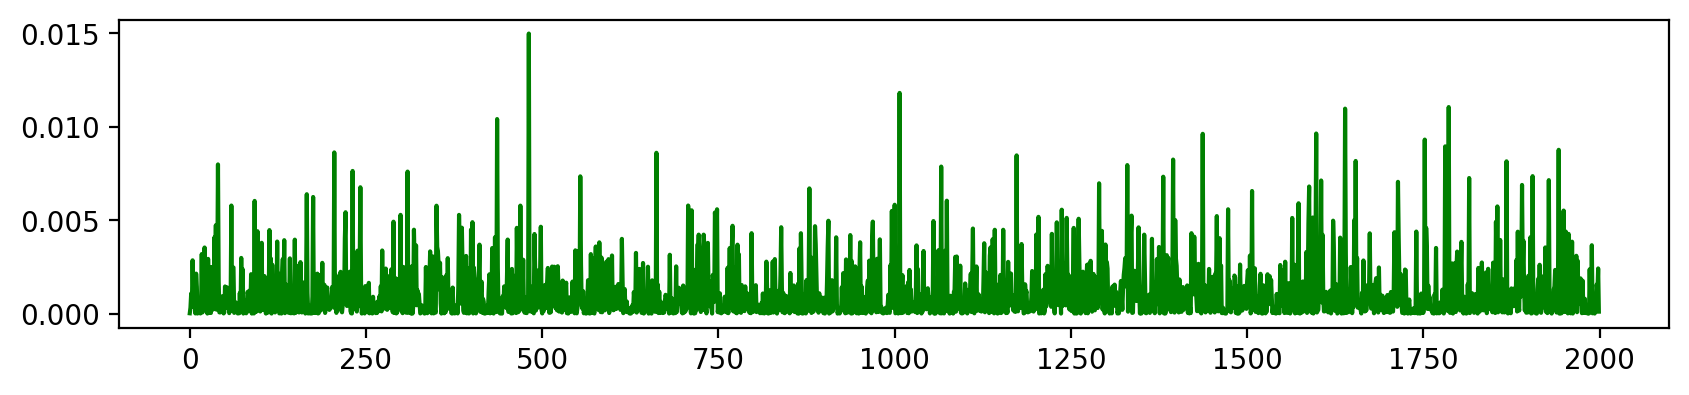

time: 146 ms (started: 2024-05-28 19:22:10 -07:00)


In [14]:
fig = plt.plot(val_reconerr_vanilla[:, [0]], color="g")

Show how the channels for the test data differ between the normal and the anomaly

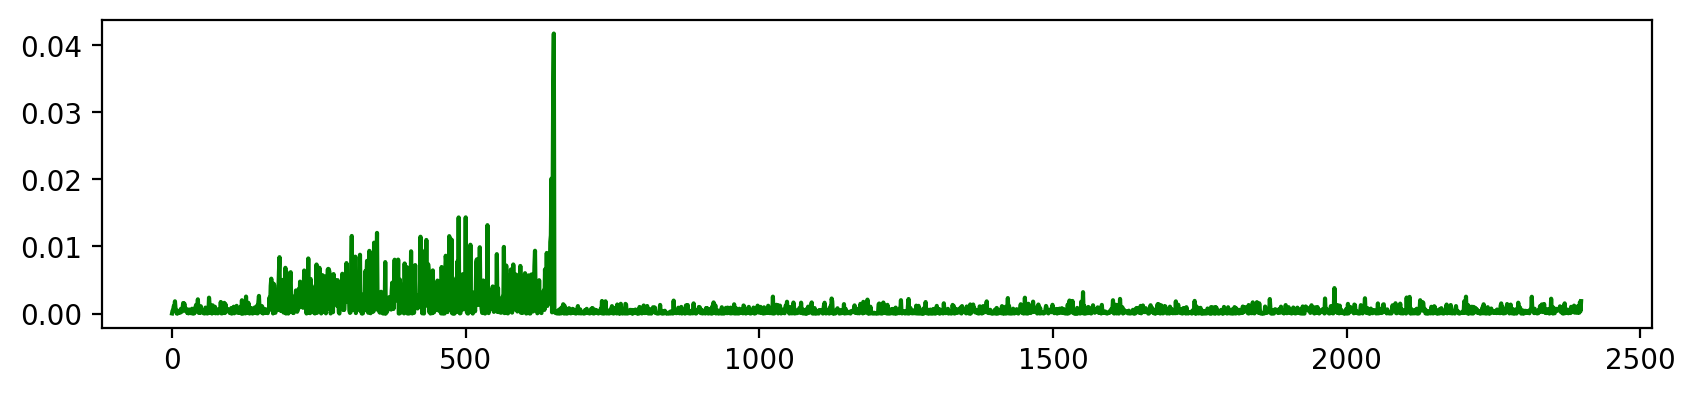

time: 127 ms (started: 2024-05-28 19:22:10 -07:00)


In [15]:
fig = plt.plot(test_reconerr_vanilla[:, [1]], color="g")

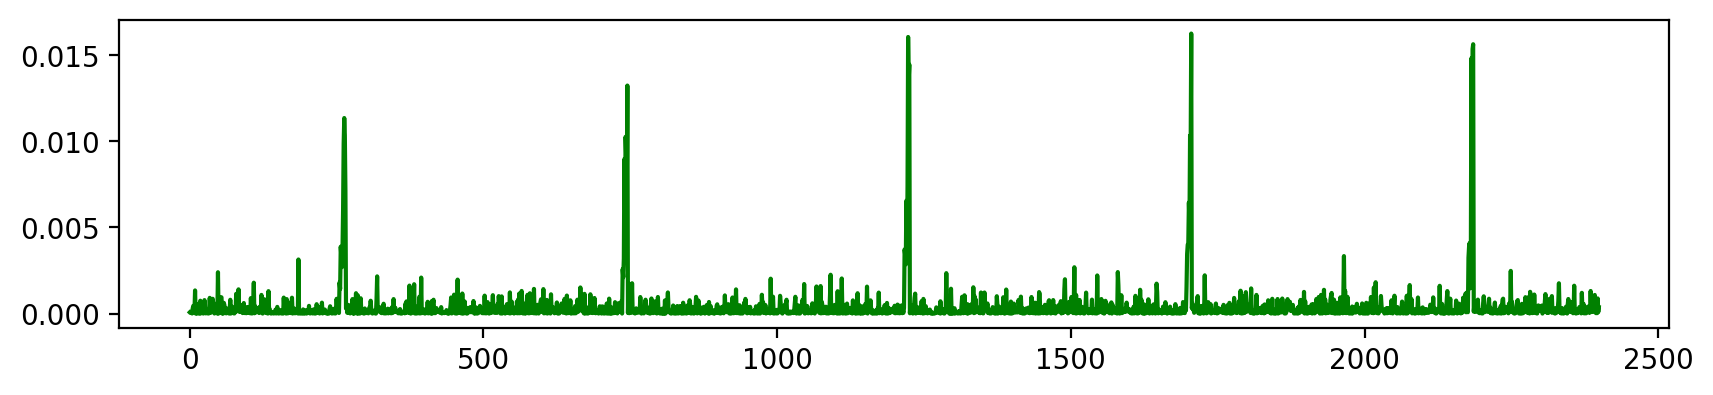

time: 126 ms (started: 2024-05-28 19:22:10 -07:00)


In [16]:
fig = plt.plot(test_reconerr_vanilla[:, [2]], color="g")

### Define a multichannel autoencoder model - constructed with three independent channel neural networks

In [17]:
from numalogic.models.autoencoder.variants import MultichannelAE
from numalogic.models.autoencoder import TimeseriesTrainer

model_multi = MultichannelAE(seq_len=SEQ_LEN, n_channels=3)
print(model_multi)

MultichannelAE(
  (channel_encoder0): _VanillaEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=12, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=8, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.25, inplace=False)
    )
  )
  (channel_decoder0): _Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=12, bias=True)
    )
  )
  (channel_encoder1): _VanillaEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=12, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=8, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.25, inplace=False)
    )
  )
  (channel_decoder1): _Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, ou

In [18]:
trainer = TimeseriesTrainer(max_epochs=MAX_EPOCHS, enable_progress_bar=True)
trainer.fit(model_multi, train_dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


time: 28.7 s (started: 2024-05-28 19:22:11 -07:00)


In [19]:
train_reconerr_multichannel = trainer.predict(
    model_multi, dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE)
).numpy()
val_reconerr_multichannel = trainer.predict(
    model_multi, dataloaders=DataLoader(val_dataset, batch_size=BATCH_SIZE)
).numpy()
test_reconerr_multichannel = trainer.predict(
    model_multi, dataloaders=DataLoader(test_dataset, batch_size=BATCH_SIZE)
).numpy()

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

time: 481 ms (started: 2024-05-28 19:22:39 -07:00)


### Compare the reconstruction errors of the different channels - the second channel should have higher error for the anomaly

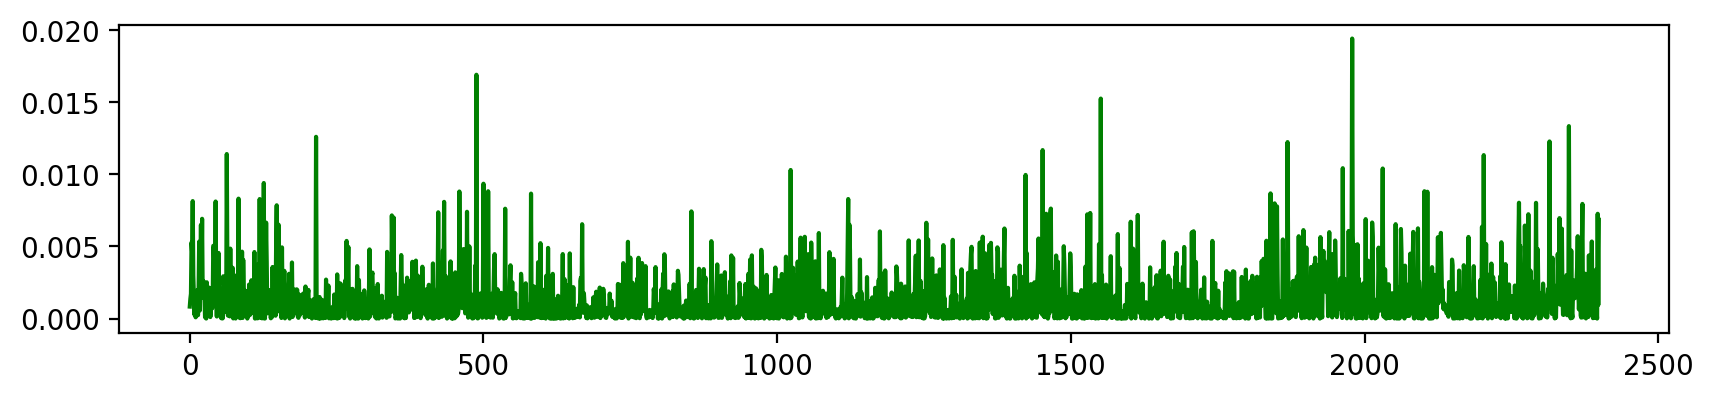

time: 135 ms (started: 2024-05-28 19:22:40 -07:00)


In [20]:
fig = plt.plot(test_reconerr_multichannel[:, [0]], color="g")

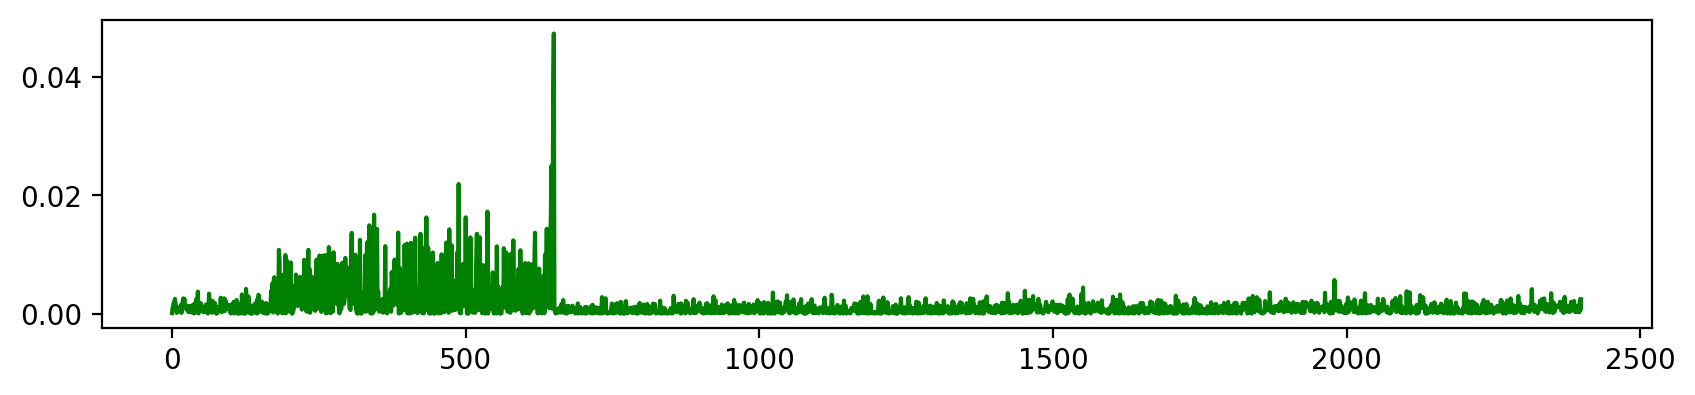

time: 114 ms (started: 2024-05-28 19:22:40 -07:00)


In [21]:
fig = plt.plot(test_reconerr_multichannel[:, [1]], color="g")

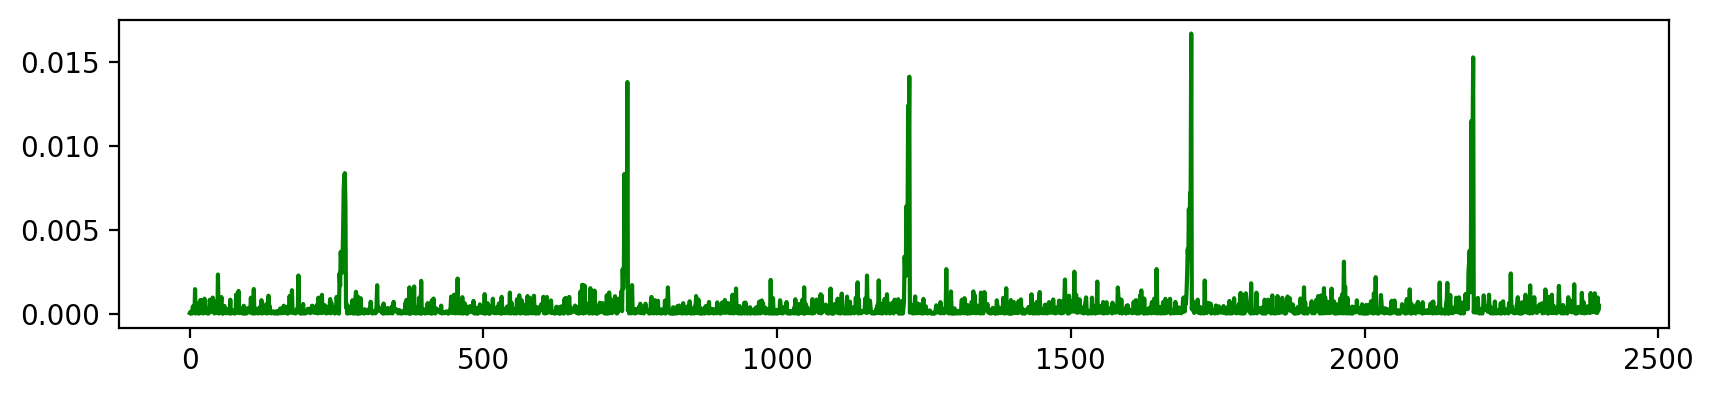

time: 118 ms (started: 2024-05-28 19:22:40 -07:00)


In [22]:
fig = plt.plot(test_reconerr_multichannel[:, [2]], color="g")

time: 122 ms (started: 2024-05-28 19:22:40 -07:00)
